A good first step to recreate the results would be to check the simple case of the diagonal.

In [1]:
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib.pyplot as plt
from functools import partial

%config InlineBackend.figure_format = 'svg'

In [2]:
# getting baseline data
data = jnp.load("u_train.npy")

In [3]:
# getting baseline 
K_baseline = jnp.load('K_baseline.npy')
diagonal_baseline = jnp.diag(K_baseline) 

On the diagonal, u=v so we need the inner product of gram and a scalar of the previous reservoir state.

In [5]:
def erf_kernel(sigma_i, sigma_r):
    def kernel(gram, k_prev):
        uv = sigma_i**2 * gram + sigma_r**2 * k_prev
        z = 2 * uv / ((1 + 2 * uv)*(1 + 2 * uv))**(1/2)
        return 2 / jnp.pi * jnp.arcsin(z)
    return kernel

def update_fn(k, x):
    x_gram = jnp.dot(x, x)
    k_next = erf_kernel(0.4, 0.9)(x_gram, k)
    return k_next, k_next

In [6]:
update_fn(0.0, data[0])

(DeviceArray(0.20486398, dtype=float32),
 DeviceArray(0.20486398, dtype=float32))

In [7]:
diagonal_baseline[0]

DeviceArray(0.21232823, dtype=float32)

Seems fairly close - now let's see what the whole thing does...

In [8]:
final, diagonal = jax.lax.scan(update_fn, 0.0, data)

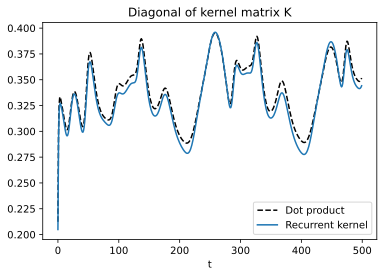

In [10]:
plt.plot(diagonal_baseline, 'k--', label='Dot product')
plt.plot(diagonal, label='Recurrent kernel')
plt.xlabel('t')
plt.title('Diagonal of kernel matrix K')
plt.legend()

Okay that seems close enough; now to do the off-diagonal elements. That'll be much more complex, so let's do it by iterating first.

In [11]:
def erf_kernel(sigma_i, sigma_r):
    def kernel(uv_gram, uu_gram, vv_gram, k_uv, k_uu, k_vv):
        uv = sigma_i**2 * uv_gram + sigma_r**2 * k_uv
        uu = sigma_i**2 * uu_gram + sigma_r**2 * k_uu
        vv = sigma_i**2 * vv_gram + sigma_r**2 * k_vv
        z = 2 * uv / ((1 + 2 * uu)*(1 + 2 * vv))**(1/2)
        return 2 / jnp.pi * jnp.arcsin(z)
    return kernel

def update_fn_lower(gram, diagonal, offset, k, idx):
    k_next = erf_kernel(0.4, 0.9)(gram[idx + offset, idx], gram[idx+offset, idx+offset], gram[idx, idx], k, diagonal[idx + offset], diagonal[idx])
    return k_next, k_next

def update_fn_upper(gram, diagonal, offset, k, idx):
    k_next = erf_kernel(0.4, 0.9)(gram[idx, idx+offset], gram[idx, idx], gram[idx+offset, idx+offset], k, diagonal[idx], diagonal[idx+offset])
    return k_next, k_next

In [12]:
%%time
k = 300 # offset
gram = jnp.dot(data, data.T)

final, off_diagonal = jax.lax.scan(partial(update_fn_lower, gram, diagonal, k), 0, jnp.arange(diagonal.shape[0] - k))

CPU times: user 360 ms, sys: 73 ms, total: 433 ms
Wall time: 534 ms


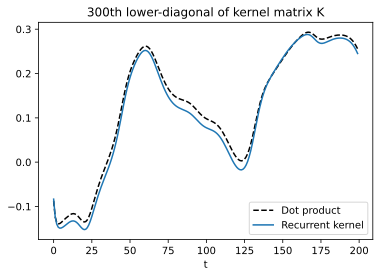

In [13]:
plt.plot(jnp.diag(K_baseline, k=-k), 'k--', label='Dot product')
plt.plot(off_diagonal, label='Recurrent kernel')
plt.xlabel('t')
plt.title(f'{k}th lower-diagonal of kernel matrix K')
plt.legend()

let's check out the upper diagonal

In [14]:
%%time
k = 300 # offset
gram = jnp.dot(data, data.T)

final, off_diagonal = jax.lax.scan(partial(update_fn_upper, gram, diagonal, k), 0, jnp.arange(diagonal.shape[0] - k))

CPU times: user 149 ms, sys: 3.14 ms, total: 152 ms
Wall time: 131 ms


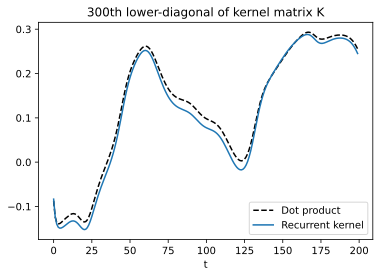

In [15]:
plt.plot(jnp.diag(K_baseline, k=k), 'k--', label='Dot product')
plt.plot(off_diagonal, label='Recurrent kernel')
plt.xlabel('t')
plt.title(f'{k}th lower-diagonal of kernel matrix K')
plt.legend()

Ofcourse - its symmetrical.

In [20]:
update_fn = update_fn_lower

okay now for all the elements:

In [21]:
diagonals = [jax.lax.scan(partial(update_fn, gram, diagonal, k), 0, jnp.arange(diagonal.shape[0] - k))[1] for k in jnp.arange(1, diagonal.size)]

In [22]:
K_recurrent = jnp.diagflat(diagonal)
for idx, diag in enumerate(diagonals):
    K_recurrent += jnp.diagflat(diag, k=-(idx+1))

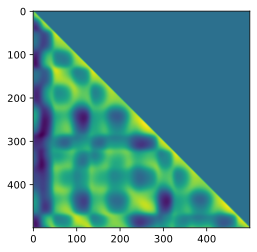

In [23]:
plt.imshow(K_recurrent)

Okay now to add it and subtract the diagonal cause its double:

In [25]:
K_recurrent_full = K_recurrent + K_recurrent.T - jnp.diagflat(diagonal)

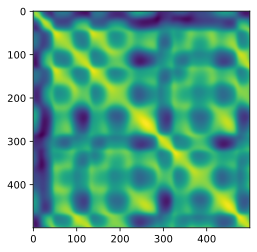

In [26]:
reLplt.imshow(K_recurrent_full)

In [38]:
abs_error = jnp.abs(K_baseline - K_recurrent_full)
rel_abs_error = abs_error / K_baseline

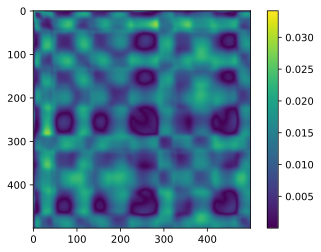

In [40]:
plt.imshow(abs_error)
plt.colorbar()

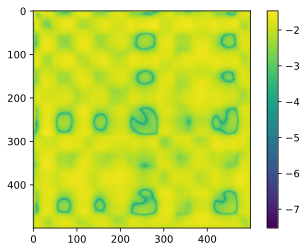

In [44]:
plt.imshow(jnp.log10(abs_error))
plt.colorbar()

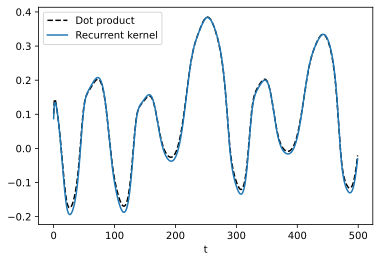

In [47]:
i = 250
plt.plot(K_baseline[i, :], 'k--', label='Dot product')
plt.plot(K_recurrent_full[i, :], label='Recurrent kernel')
plt.xlabel('t')
plt.legend()

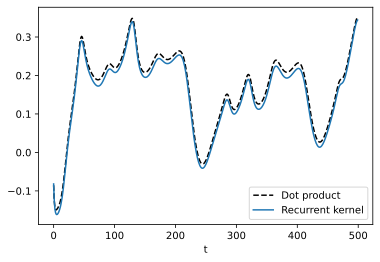

In [51]:
j = 499
plt.plot(K_baseline[:, j], 'k--', label='Dot product')
plt.plot(K_recurrent_full[:, j], label='Recurrent kernel')
plt.xlabel('t')
plt.legend()

In [52]:
jnp.save('K_recurrent.npy', K_recurrent_full)